# Global Health Medical Center -  Bone Fracture Image Classification with PyTorch

## Business Scenario

In the rapidly evolving field of medical diagnostics, timely and accurate detection of bone fractures can significantly impact patient outcomes and healthcare efficiency. Emergency rooms and clinics around the world are often overwhelmed, leading to delayed diagnoses and increased patient suffering. 

Imagine a scenario where a state-of-the-art AI system assists medical professionals by providing rapid, reliable, and precise identification of bone fractures from X-ray images. This technology can help reduce diagnostic errors, expedite treatment decisions, and ultimately save lives. By leveraging advanced machine learning techniques and powerful neural networks, this project aims to develop an automated solution for bone fracture detection.

This bone fracture classification system can be integrated into existing hospital workflows, assisting radiologists in their decision-making process. It can serve as a second opinion, catching fractures that might be missed during a busy shift or by less experienced practitioners. Additionally, in rural or under-resourced settings, where access to expert radiologists is limited, this AI system can provide critical support, ensuring that patients receive the care they need, when they need it.

By leveraging advanced machine learning techniques and a sophisticated convolutional neural network (CNN) architecture, this project seeks to develop a robust and reliable model for bone fracture detection. This AI system will provide significant support in:
- **Reducing diagnostic errors**: Acting as a second pair of eyes for radiologists, the system helps catch fractures that might be missed during hectic shifts or by less experienced practitioners.
- **Expediting treatment decisions**: Rapid and accurate fracture detection enables quicker treatment initiation, improving patient outcomes.
- **Enhancing healthcare accessibility**: In rural or under-resourced settings, where access to expert radiologists is limited, the AI system can provide essential diagnostic support.

Welcome to the future of medical diagnostics, where technology and healthcare unite to enhance patient care and streamline medical processes. Let's dive into the development of this groundbreaking bone fracture image classification model.


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import os
from sklearn.model_selection import train_test_split


## Data Preparation

We'll prepare the dataset with data augmentation for the training set and normalization for all sets.

In [2]:
# Data transformations with augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((224, 224)),  # Resize to a fixed size
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the data
train_dataset = datasets.ImageFolder(root='bonedata/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='bonedata/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='bonedata/test', transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Model Definition

We'll use a pre-trained ResNet model and fine-tune it for our specific task.


In [5]:
model = models.resnet18(weights=True)

# Modify the first convolutional layer to accept single-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final layer to match the number of classes (binary classification in this case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Loss Function and Optimizer

We'll use the Cross Entropy Loss and the Adam optimizer. A learning rate scheduler will also be used to adjust the learning rate during training.


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Training the Model

We'll train the model for a set number of epochs, evaluate it on the validation set, and adjust the learning rate using the scheduler.


In [28]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0

    for images, labels in train_loader:
        try:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            try:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
            except Exception as e:
                print(f"Error processing batch: {e}")
                continue

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_loader.dataset)
    
    # Adjust the learning rate
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

C:\Users\Mamdouh\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/25, Train Loss: 0.0241, Train Accuracy: 0.9897, Validation Loss: 0.9056, Validation Accuracy: 0.7551
Epoch 2/25, Train Loss: 0.0501, Train Accuracy: 0.9813, Validation Loss: 0.1592, Validation Accuracy: 0.9180
Epoch 3/25, Train Loss: 0.0168, Train Accuracy: 0.9938, Validation Loss: 0.0958, Validation Accuracy: 0.9554
Epoch 4/25, Train Loss: 0.0097, Train Accuracy: 0.9965, Validation Loss: 0.0879, Validation Accuracy: 0.9614
Epoch 5/25, Train Loss: 0.0090, Train Accuracy: 0.9966, Validation Loss: 0.0777, Validation Accuracy: 0.9662
Epoch 6/25, Train Loss: 0.0072, Train Accuracy: 0.9977, Validation Loss: 0.0763, Validation Accuracy: 0.9686
Epoch 7/25, Train Loss: 0.0070, Train Accuracy: 0.9975, Validation Loss: 0.0696, Validation Accuracy: 0.9698
Epoch 8/25, Train Loss: 0.0063, Train Accuracy: 0.9975, Validation Loss: 0.0629, Validation Accuracy: 0.9747
Epoch 9/25, Train Loss: 0.0054, Train Accuracy: 0.9983, Validation Loss: 0.0590, Validation Accuracy: 0.9747
Epoch 10/25, Train 

## Testing the Model

Finally, we'll evaluate the trained model on the test set.

In [29]:
model.eval()
test_loss = 0
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = test_correct / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0424, Test Accuracy: 0.9802


## Test a Single Image

We'll add a function to test a single image for a fracture prediction (Real Image of my broken leg finger).

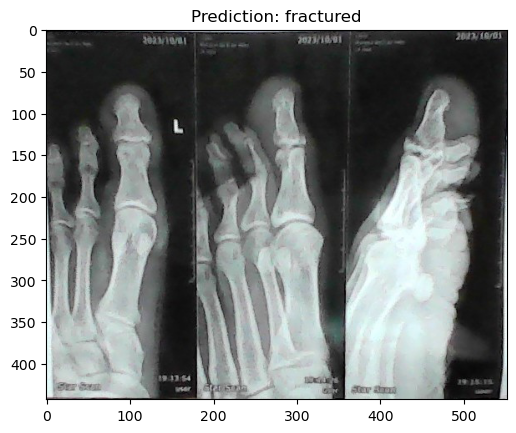

The image is predicted to be: fractured


In [30]:
import PIL.Image as Image
import matplotlib.pyplot as plt

def predict_image(image_path, model, transform, class_names):
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    
    # Predict the class
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    predicted_class = class_names[predicted.item()]
    
    # Show the image and prediction
    plt.imshow(Image.open(image_path), cmap="gray")
    plt.title(f'Prediction: {predicted_class}')
    plt.show()
    
    return predicted_class

# Class names based on the dataset folder structure
class_names = train_dataset.classes

# Path to the image you want to test
test_image_path = 'finger_broke.jpg'

# Predict and display the result
predicted_class = predict_image(test_image_path, model, val_test_transform, class_names)
print(f'The image is predicted to be: {predicted_class}')


## Conclusion

In this notebook, we built an advanced image classification model using a pre-trained ResNet and fine-tuned it to detect bone fractures. We used data augmentation, a learning rate scheduler, and evaluated the model on separate training, validation, and test sets to ensure robust performance. We also added functionality to test individual images for fracture predictions, making this project a comprehensive and practical tool for bone fracture detection.
